## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result

## A faire : 

- Sauvegarder modèles 
- Fonction pour refaire echantillon train / test à chque fois 
- TensorBoard

git add NomFichier (dans "Projet/Notebooks")  
git commit -m "NomFichier"  
git push origin main

## 1 - Imports

In [1]:
import tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plot_keras_history import plot_history

## 2 - Récupérer les données

In [2]:
data_river = pd.read_csv("../databases/PEPSIR_acc_clim_lc_beck_V4.csv", sep=";")
#data_river = pd.read_csv("../databases/PEPSIR_raw_LF_perfect.csv", sep=";")
display(data_river.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_river.isna().sum().sum(), '  Shape is : ', data_river.shape)

,river,day,reach,reach_length,lon,lat,QWBM,flowacc,stage,dH,W,dA,S,U,A0,Abar,Sbar,clay,sand,silt,PA,TA,LC1,LC2,LC3,LC4,LC5,LC6,LC7,LC8,LC9,LC10,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,Connecticut,1,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,26.306667,1.386667,475.403333,541.200050,0.001768,0.965178,515.403333,821.447783,0.001600,nan,nan,nan,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,922.263333
1,Connecticut,2,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.960000,1.040000,443.906667,381.870528,0.001606,0.704906,515.403333,821.447783,0.001600,nan,nan,nan,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,581.980000
2,Connecticut,3,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.810000,0.890000,427.006667,316.600322,0.001539,0.595232,515.403333,821.447783,0.001600,nan,nan,nan,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,460.586667
3,Connecticut,4,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.776667,0.856667,423.786667,302.424628,0.001521,0.569428,515.403333,821.447783,0.001600,nan,nan,nan,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,435.253333
4,Connecticut,5,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.616667,0.696667,406.016667,236.099400,0.001469,0.471288,515.403333,821.447783,0.001600,nan,nan,nan,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,334.273333


Missing Data :  184125   Shape is :  (61375, 42)


In [11]:
# Missing data = 34 => présence de valeurs NaN dans le tableau => on les retire
full_nan = ['clay','sand','silt'] #drop clay, silt & sand, beacause all of them are nan
data = data_river.drop(full_nan,axis=1)

data.dropna(inplace=True)
display(data.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data.isna().sum().sum(), 'Shape is : ', data.shape )

,river,day,reach,reach_length,lon,lat,QWBM,flowacc,stage,dH,W,dA,S,U,A0,Abar,Sbar,PA,TA,LC1,LC2,LC3,LC4,LC5,LC6,LC7,LC8,LC9,LC10,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,Connecticut,1,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,26.306667,1.386667,475.403333,541.200050,0.001768,0.965178,515.403333,821.447783,0.001600,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,922.263333
1,Connecticut,2,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.960000,1.040000,443.906667,381.870528,0.001606,0.704906,515.403333,821.447783,0.001600,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,581.980000
2,Connecticut,3,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.810000,0.890000,427.006667,316.600322,0.001539,0.595232,515.403333,821.447783,0.001600,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,460.586667
3,Connecticut,4,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.776667,0.856667,423.786667,302.424628,0.001521,0.569428,515.403333,821.447783,0.001600,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,435.253333
4,Connecticut,5,1,3732.718894,-72.611298,41.959000,394.107544,25078.300781,25.616667,0.696667,406.016667,236.099400,0.001469,0.471288,515.403333,821.447783,0.001600,1165.777778,9.429297,4.900826,0.859504,37.892562,14.975207,0.000000,2.950413,14.900826,0.000000,21.677686,0.000000,0.000000,1.884298,132813.737318,94894.944028,66221.529377,17385218.105210,12201.771829,8168.422433,6608.860677,334.273333


Missing Data :  0 Shape is :  (61375, 39)


## 3 - Préparation des données
### 3.1 Suppresion des débits <100

In [48]:
#data_river = data_river.loc[data_river['Q']>70]

#data_river.head()

,site_no,station_name,lon,lat,flowacc,stage,W,dH,dA,U,...,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
1,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.58,47.28,15356.039445,2.654808,219.4560,2.261616,300.786608,0.667512,...,0.0,1.190083,99502.325185,61157.019143,33797.196081,9.594206e+06,6429.734027,4146.406794,3498.886439,87.782224
2,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.58,47.28,15356.039445,2.712720,190.5000,2.319528,312.657294,0.966216,...,0.0,1.190083,99502.325185,61157.019143,33797.196081,9.594206e+06,6429.734027,4146.406794,3498.886439,529.525031
3,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.58,47.28,15356.039445,6.263640,202.3872,5.870448,1033.768321,1.996440,...,0.0,1.190083,99502.325185,61157.019143,33797.196081,9.594206e+06,6429.734027,4146.406794,3498.886439,2500.377554
4,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.58,47.28,15356.039445,7.150608,206.0448,6.757416,1220.685874,2.209800,...,0.0,1.190083,99502.325185,61157.019143,33797.196081,9.594206e+06,6429.734027,4146.406794,3498.886439,3228.120511
5,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.58,47.28,15356.039445,8.263128,212.4456,7.869936,1453.475344,2.484120,...,0.0,1.190083,99502.325185,61157.019143,33797.196081,9.594206e+06,6429.734027,4146.406794,3498.886439,4332.477529


### 3.2 Choisir les données

In [12]:
to_drop = ['stage','dA','U','S','A0','Abar','Sbar','PA','TA','river','day','reach','reach_length','lon','lat','QWBM','Q5_GSCD','Q10_GSCD','Q20_GSCD','QMEAN_GSCD','Q80_GSCD','Q90_GSCD',
           'Q95_GSCD','LC1','LC2','LC3','LC4','LC5','LC6','LC7','LC8','LC9','LC10','LC11','LC12']

# Pas U mais flowacc

# Pente du terrain

#Autre méthode
#columns_used=['date','pmer','tend','cod_tend','dd','ff','td','u','ww','pres','rafper','per','rr1','rr3','tc']

# ---- Drop unused columns

#to_drop = df.columns.difference(columns_used)
#df.drop( to_drop, axis=1, inplace=True)


data = data.drop(to_drop,axis=1)

display(data.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,flowacc,dH,W,Q
0,25078.300781,1.386667,475.403333,922.263333
1,25078.300781,1.040000,443.906667,581.980000
2,25078.300781,0.890000,427.006667,460.586667
3,25078.300781,0.856667,423.786667,435.253333
4,25078.300781,0.696667,406.016667,334.273333


Missing Data :  0   Shape is :  (61375, 4)


### 3.2 Séparer les données

80% pour train - 20% pour test

x -> input data

y -> expected output

In [13]:
# ---- Suffle and Split => train, test
def shuffle(data): 
    
    data_train = data.sample(frac=0.8, axis=0) # peut être fait avec n = 'nombre de données voulues'
    data_test  = data.drop(data_train.index) # retire les données choisies
    display(data_train.head())

    # ---- Split => x,y
    #
    x_train = data_train.drop('Q',  axis=1)
    y_train = data_train['Q'] 
    x_test  = data_test.drop('Q',   axis=1)
    y_test  = data_test['Q']


    print('Original data shape was : ',data.shape)
    print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
    print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
    
    return x_train, y_train , x_test, y_test

### 3.3 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [14]:
def normalization(x_train,y_train,x_test,y_test):
    #display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

    mean = x_train.mean()
    std  = x_train.std()
    x_train = (x_train - mean) / std
    x_test  = (x_test  - mean) / std


    #mean = y_train.mean()
    #std  = y_train.std()

    #y_train = (y_train - mean) / std
    #y_test  = (y_test  - mean) / std

    display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
    display(x_train.head().style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test,  y_test  = np.array(x_test),  np.array(y_test)
    return x_train, y_train , x_test, y_test

In [15]:
x_train, y_train , x_test, y_test = shuffle(data)

x_train, y_train , x_test, y_test = normalization(x_train,y_train,x_test,y_test)

,flowacc,dH,W,Q
25124,28558.599609,0.561545,218.620529,219.135817
45298,234181.203125,0.091250,315.848750,372.786667
25252,28558.599609,0.110563,214.603639,144.452856
771,41151.000000,0.302500,157.672500,168.697500
44627,234181.203125,0.119200,363.126800,701.454400


Original data shape was :  (61375, 4)
x_train :  (49100, 3) y_train :  (49100,)
x_test  :  (12275, 3) y_test  :  (12275,)


,flowacc,dH,W
count,49100.00,49100.00,49100.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-0.67,-0.90,-0.36
25%,-0.62,-0.70,-0.29
50%,-0.54,-0.31,-0.25
75%,-0.21,0.30,-0.11
max,4.01,6.85,11.51


,flowacc,dH,W
25124,-0.62,-0.59,-0.27
45298,-0.21,-0.85,-0.23
25252,-0.62,-0.84,-0.28
771,-0.59,-0.73,-0.30
44627,-0.21,-0.83,-0.21


# Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [16]:
def get_model_v1(shape,n_layers,n_neurons): 
    
    # shape : nb de variables explicatives 
    # n_layers : nb de couches
    # n_neurons : neurons/ couche
   
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    
    for i in range(n_layers): 
            model.add(keras.layers.Dense(n_neurons, activation='relu', name='Dense_n'+str(i)))
   
    model.add(keras.layers.Dense(1, name='Output'))
    model.compile(optimizer = 'adam', 
                  loss      = 'mae',
                  metrics   = ['mae', 'mse'] )
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [17]:
shape = data.shape[1]-1
n_layers = 10
n_neurons = 32
model=get_model_v1((shape,),n_layers,n_neurons)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n0 (Dense)             (None, 32)                128       
_________________________________________________________________
Dense_n1 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n2 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n3 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n4 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n5 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n6 (Dense)             (None, 32)                1

### 5.2 Train it

In [18]:
x_train, y_train , x_test, y_test = shuffle(data)
x_train, y_train , x_test, y_test = normalization(x_train,y_train,x_test,y_test)

,flowacc,dH,W,Q
31261,8.484700e+03,0.194495,75.921232,36.529145
38693,1.060506e+06,2.557600,224.314120,1024.096900
50480,2.341812e+05,0.312000,580.373200,4186.206800
41719,1.060506e+06,2.577178,256.766700,1257.589111
75,2.507830e+04,1.006667,438.756667,565.566667


Original data shape was :  (61375, 4)
x_train :  (49100, 3) y_train :  (49100,)
x_test  :  (12275, 3) y_test  :  (12275,)


,flowacc,dH,W
count,49100.00,49100.00,49100.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-0.67,-0.90,-0.36
25%,-0.62,-0.70,-0.29
50%,-0.54,-0.31,-0.25
75%,-0.21,0.31,-0.11
max,4.02,6.88,11.66


,flowacc,dH,W
31261,-0.66,-0.79,-0.34
38693,1.43,0.52,-0.27
50480,-0.21,-0.73,-0.10
41719,1.43,0.53,-0.26
75,-0.62,-0.34,-0.17


In [19]:
ep = 50

history = model.fit(x_train,
                    y_train,
                    epochs          = ep,
                    batch_size = 50, 
                    verbose         = 0,
                    validation_data = (x_test, y_test))

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [20]:
score = model.evaluate(x_test, y_test, verbose=1)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

384/384 [==============================] - 1s 1ms/step - loss: 585.9879 - mae: 585.9879 - mse: 3289437.7500
x_test / loss      : 585.9879
x_test / mae       : 585.9879
x_test / mse       : 3289437.7500


### 6.2 - Training history
What was the best result during our training ?

In [23]:
df=pd.DataFrame(data=history.history)
display(df.head().style.format("{0:.2f}").set_caption("Début du training:"))
display(df.tail().style.format("{0:.2f}").set_caption("Fin du training :"))

,loss,mae,mse,val_loss,val_mae,val_mse
0,1399.44,1399.44,15342883.00,979.25,979.25,7364515.00
1,896.67,896.67,7155769.00,836.01,836.01,6318163.00
2,823.41,823.41,6318978.50,859.97,859.97,5932449.00
3,774.01,774.01,5782865.50,757.64,757.64,5603069.00
4,746.65,746.65,5591441.50,748.65,748.65,5271743.50


,loss,mae,mse,val_loss,val_mae,val_mse
45,583.59,583.59,3580241.25,609.19,609.19,3599864.50
46,577.28,577.28,3512439.25,576.30,576.30,3272624.25
47,582.01,582.01,3544680.00,610.62,610.62,3872807.25
48,575.55,575.55,3518922.50,656.24,656.24,3588933.50
49,570.18,570.18,3479114.25,585.99,585.99,3289438.75


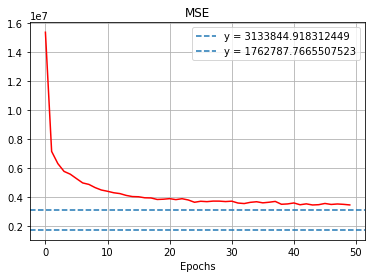

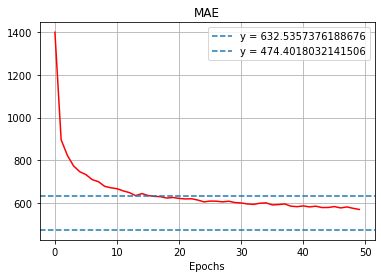

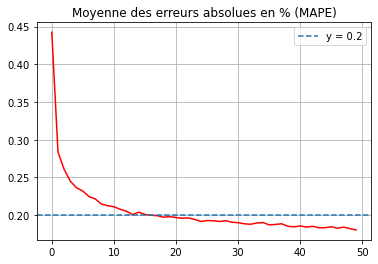

In [24]:
plt.plot(df['mse'],'r')
plt.title('MSE')
plt.xlabel('Epochs')
plt.axhline(np.mean(y_train**2)*0.04,ls='--',label='y = ' + str(0.04*np.mean(y_train**2)))
plt.axhline(np.mean(y_train**2)*0.15**2,ls='--',label='y = ' + str(0.15**2*np.mean(y_train**2)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mae'],'r')
plt.title('MAE')
plt.xlabel('Epochs')
plt.axhline(0.2*np.mean(y_train),ls='--',label='y = ' +str(0.2*np.mean(y_train)))
plt.axhline(0.15*np.mean(y_train),ls='--',label='y = ' +str(0.15*np.mean(y_train)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mae']/np.mean(y_train),'r') # MAPE
plt.axhline(0.20,ls='--',label='y = 0.2')
plt.grid()
plt.title('Moyenne des erreurs absolues en % (MAPE)')
plt.legend()
plt.show()

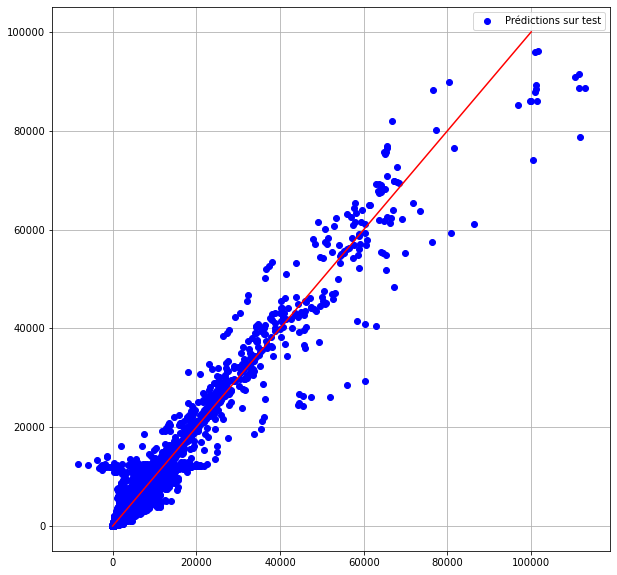

In [26]:
plt.figure(figsize=(10,10))
plt.plot(y_test,model.predict(x_test),'bo',label='Prédictions sur test')
x = np.arange(0,100000)
plt.plot(x,x,'r')
#plt.plot(x,x+0.20*x,'--g')
#plt.plot(x,x-0.20*x,'--g')
plt.legend()
plt.grid()
plt.show()

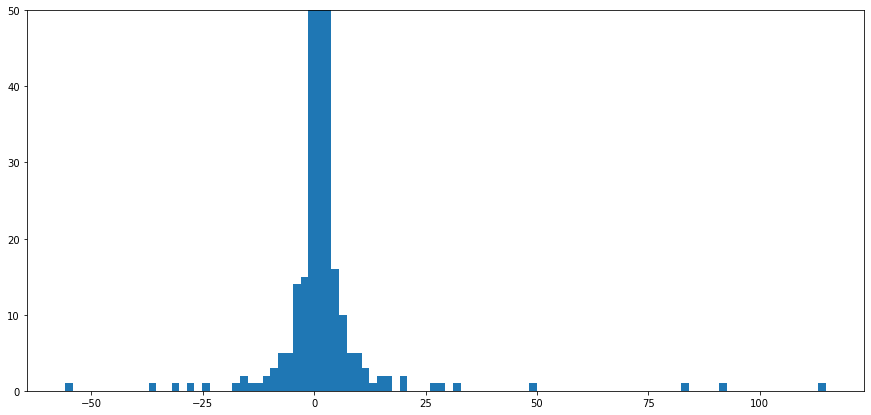

In [28]:
yt = y_test.reshape(y_test.shape[0],1)
plt.figure(figsize=(15,7))
plt.hist((model.predict(x_test)-yt)/yt,bins=100)
plt.ylim(0,50)
plt.show()

## Save the model

In [44]:
model.save('../Models/model_'+str(n_layers)+'_'+str(n_neurons)+'_'+str(ep))

## Autre

In [25]:
print("Weights and biases of the layers after training the model: \n")
for layer in model.layers:
    print("Layer : " , layer.name)
    print("Weights : ",layer.get_weights()[0].shape)
    print(layer.get_weights()[0])
    print("Bias")
    print("Shape: ",layer.get_weights()[1].shape,'\n',layer.get_weights()[1],'\n')

Weights and biases of the layers after training the model: 

Layer :  Dense_n0
Weights :  (3, 32)
[[ 0.12430572 -0.1864143   0.23605712  0.38809282  0.42920703 -0.11493806
  -0.38151443 -0.25323078 -0.56953484 -0.3505973  -0.08373705 -0.6518897
   0.20296134 -0.23133056 -0.15235345  0.25557488  0.19677365 -0.10561521
   0.341042   -0.23694412 -0.5008083   0.4544403   0.52171934 -0.04927532
   0.34803024  0.25609246  0.03168377  0.4348208   0.09950986 -0.3292885
   0.38816148  0.16939634]
 [-0.46478054 -0.62251383 -0.5938417   0.01782081  0.25786874 -0.20690721
  -0.24264656  0.54161173 -0.3550436  -0.06930789 -0.5732138   0.49458593
   0.5052639  -0.34648314  0.2632428   0.06776212  0.3075747  -0.0587228
  -0.04512123  0.25570208  0.06767022 -0.19151098 -0.11029083  0.05269817
   0.34244585 -0.18353277  0.20088108 -0.21020645 -0.28825158  0.10151169
   0.19209094 -0.3036378 ]
 [-0.17004399  0.43054     0.45442665  0.55733806 -0.02950812  0.33106965
  -0.6229714   0.13923728  0.41078547